In [199]:
from sage.all import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sage.ext.fast_callable import fast_callable


pretty_print_default(True)
%display latex

In [200]:
Λ, τ, σ, μ, θ = var('Lambda','tau','sigma', 'mu', 'theta')
σ2 = σ^2

In [201]:
def get_tau_vars(d):
    diag = [var(f'tau{i}{i}') for i in range(1, d+1)]
    off  = [var(f'tau{i}{j}') for i in range(1, d+1) for j in range(i+1, d+1)]
    return diag + off

def precision_matrix(d):
    if d==2:
        C = Matrix([[3/8,1/8,0],
                    [1/8,3/8,0],
                    [0,  0,  1/8]])
    elif d==3:
        C = Matrix([[1/5, 1/15,1/15, 0,    0,    0],
                    [1/15,1/5, 1/15, 0,    0,    0],
                    [1/15,1/15,1/5,  0,    0,    0],
                    [0,   0,   0,    1/15, 0,    0],
                    [0,   0,   0,    0,    1/15, 0],
                    [0,   0,   0,    0,    0,    1/15]] )
    else:
        raise ValueError("Only d=2 or 3 supported")
    return C.inverse()

In [202]:
def delta_contrast_Zel(d):
    """
    The Zeldovich toy-model Δ(τ): one convenient default delta_func.
    """
    taus = get_tau_vars(d)
    T = Matrix(SR, d); k = 0
    for i in range(d):
        T[i,i] = taus[k]; k += 1
    for i in range(d):
        for j in range(i+1,d):
            T[i,j] = T[j,i] = taus[k]; k += 1
    return 1/((identity_matrix(SR,d) - T).det()) - 1

# Ellipsoidal collapse in terms of τ‐variables (Eq. 5.3):
def delta_contrast_ellipsoidal(d, nu_param = var('nu')):
    """
    Ellipsoidal‐collapse density contrast Δ(τ) ≡ ρ(τ) − 1
      - d         : dimension (e.g. 3)
      - nu_param  : ellipticity exponent ν
    """
    if nu_param == None:
        nu_param = d

    taus = get_tau_vars(d)
    T = Matrix(SR, d); k = 0
    for i in range(d):
        T[i,i] = taus[k]; k += 1
    for i in range(d):
        for j in range(i+1,d):
            T[i,j] = T[j,i] = taus[k]; k += 1
    
    # 2) linear contrast δ = sum_i tau_ii
    delta_lin = T.trace()
    
    # 3) build the total density ρ(τ) and subtract 1 to get Δ
    rho = (1 - delta_lin/d)^d / (1 - delta_lin/nu_param)^nu_param / ((identity_matrix(SR,d) - T).det())

    return rho - 1

def theta_Zel(d):
    """
    Zeldovich velocity-divergence map:
      theta = - Tr[(I - T)^(-1) T]
    (f=1 assumed; multiply by f(eta) if needed).
    """
    taus = get_tau_vars(d)
    T = Matrix(SR, d)
    k = 0
    for i in range(d):
        T[i,i] = taus[k]; k += 1
    for i in range(d):
        for j in range(i+1, d):
            T[i,j] = T[j,i] = taus[k]; k += 1

    IminT_inv = (identity_matrix(SR, d) - T).inverse()
    return -(IminT_inv * T).trace().factor()

In [203]:
def theta_Zel_spherical(d):
    theta = theta_Zel(d)
    taus = get_tau_vars(d)
    subs = {v: τ for v in taus[:d]}
    subs.update({v: 0 for v in taus[d:]})
    return theta.subs(subs).factor()

In [204]:
theta_Zel_spherical(3)

3*tau/(tau - 1)

In [ ]:
# 2) Joint action in the full tau-space
def action_joint(d, Λ, μ, nu=None):
    taus = get_tau_vars(d)
    Δ    = delta_contrast_ellipsoidal(d, nu)
    θ    = theta_Zel(d)
    P    = precision_matrix(d)
    quad = sum(taus[i] * sum(P[i,j]*taus[j] for j in range(len(taus)))
               for i in range(len(taus)))
    return Λ*Δ + θ*μ - (1/2)*quad

# 3) Spherical reduction: τ_{ij} = τ * δ_{ij} -> single var
def action_spherical_joint(d, Λ, μ, nu=None):
    # substitute τ_ii=τ, τ_ij≠i=0 into joint action
    S_full = action_joint(d, Λ, μ, nu)
    taus = get_tau_vars(d)
    subs = {v: τ for v in taus[:d]}
    subs.update({v: 0 for v in taus[d:]})
    return S_full.subs(subs)


In [223]:
def hessian_joint_full(d, Λ, μ, nu=None):
    taus = get_tau_vars(d)
    S    = action_joint(d, Λ, μ, nu)
    n    = len(taus)
    H    = Matrix(SR, n, n)
    for i in range(n):
        for j in range(n):
            H[i,j] = diff(S, taus[i], taus[j])
    return H
def hessian_spherical(d, Λ, μ, nu=None):
    Hf   = hessian_joint_full(d, Λ, μ, nu)
    taus = get_tau_vars(d)
    subs = {v:τ for v in taus[:d]}
    subs.update({v:0 for v in taus[d:]})
    return Hf.subs(subs).apply_map(lambda x: x.factor())


In [226]:
def saddle_equation(d,nu=None):
    S_tau = action_spherical_joint(d, Λ, μ, nu)
    eq = diff(S_tau, τ).numerator().factor()
    return eq

In [231]:
show("Saddle eq (d=2):", saddle_equation(2).factor() == 0)
show("Saddle eq (d=3):", saddle_equation(3).factor() == 0)

'Saddle eq (d=2):' -4*tau^4 + 12*tau^3 - 2*mu*tau - 12*tau^2 - 2*Lambda + 2*mu + 4*tau == 0

'Saddle eq (d=3):' -9*tau^5 + 36*tau^4 - 3*mu*tau^2 - 54*tau^3 + 6*mu*tau + 36*tau^2 + 3*Lambda - 3*mu - 9*tau == 0

In [232]:
def one_loop_correction_joint(d, Λ, μ, nu=None):
    Hj = -hessian_spherical(d, Λ, μ, nu)
    return - (1/2) * log( (Hj.det()/precision_matrix(d).det()).factor() )

def CGF_NLO_joint(d, Λ, μ, σ2, total_order=4, nu=None):
    φ0 = joint_CGF_series(d, total_order, nu)
    F1 = one_loop_correction_joint(d, Λ, μ, nu)
    return (φ0 + σ2*F1).factor()


In [233]:
show(one_loop_correction_joint(2, Λ, μ))
show(one_loop_correction_joint(2, Λ=(2*τ*(1-τ)**3), μ=0))

-1/2*log(1/32*(4*tau^4 - 16*tau^3 - 2*mu*tau + 24*tau^2 - Lambda + 2*mu - 16*tau + 4)^2*(2*tau^4 - 8*tau^3 - 2*mu*tau + 12*tau^2 - 3*Lambda + 2*mu - 8*tau + 2)/(tau - 1)^12)

-1/2*log(1/4*(4*tau - 1)*(3*tau - 2)^2/(tau - 1)^3)

In [235]:
def tau_series(d, total_order=4, nu=None):
    """
    Return τ(μ,Λ) to the requested total order
    using Hensel/Newton lifting inside a power-series ring.
    """    
    # total-degree default_prec must exceed the order we want
    R.<mu, Lambda> = PowerSeriesRing(QQ, default_prec=total_order+2)
    PR.<tau>       = PolynomialRing(R)
    # build polynomial version of the saddle equation
    P_poly   = PR(saddle_equation(d, nu=nu).expand())
    dP_poly  = P_poly.derivative()

    # initial guess: constant term killing P at O(mu, Lambda)
    root = PR((Lambda - mu)/d)

    # Newton–Hensel lift in the polynomial ring over R
    for k in range(1, total_order+1):
        valP  = P_poly(root)
        valdP = dP_poly(root)
        # Convert to power series and truncate before division
        valP_trunc = R(valP).truncate(k+1)
        valdP_trunc = R(valdP).truncate(k+1)
        correction = valP_trunc / valdP_trunc
        root = root - PR(correction)
        root = root.truncate(k+1)

    return R(root).truncate(total_order+1).add_bigoh(total_order+1)

# examples for both dimensions
show("τ* (d=2):", tau_series(2))
show("τ* (d=3):", tau_series(3))


'τ* (d=2):' -1/2*mu + 1/2*Lambda + 1/2*mu^2 - 5/4*mu*Lambda + 3/4*Lambda^2 - 7/8*mu^3 + 7/2*mu^2*Lambda - 9/2*mu*Lambda^2 + 15/8*Lambda^3 + 15/8*mu^4 - 165/16*mu^3*Lambda + 165/8*mu^2*Lambda^2 - 143/8*mu*Lambda^3 + 91/16*Lambda^4 + O(mu, Lambda)^5

'τ* (d=3):' -1/3*mu + 1/3*Lambda + 2/9*mu^2 - 2/3*mu*Lambda + 4/9*Lambda^2 - 7/27*mu^3 + 4/3*mu^2*Lambda - 55/27*mu*Lambda^2 + 26/27*Lambda^3 + 10/27*mu^4 - 220/81*mu^3*Lambda + 182/27*mu^2*Lambda^2 - 560/81*mu*Lambda^3 + 68/27*Lambda^4 + O(mu, Lambda)^5

In [236]:
from sage.all import QQ, PowerSeriesRing, var
from sage.misc.sage_eval import sage_eval

def joint_CGF_series(d, total_order=4, nu=None):
    """
    Generic LO joint CGF S(μ,Λ) as a multivariate power series.
    Relies on your existing saddle_equation() and action_spherical_joint().
    """

    # ─── 0) set up the *symbolic* variables ──────────────────────────────
    mu_sym, Lambda_sym, tau_sym = var('mu', 'Lambda', 'tau')

    # ─── 1) build the *power*-series ring R and its τ–polynomial ring S ─
    R.<mu,Lambda> = PowerSeriesRing(QQ, default_prec=total_order+2)
    S.<tau>   = R[]

    # ─── helper to re-parse a symbolic expr into *this* ring ────────────
    def _to_ring(expr_sym):
        return sage_eval(str(expr_sym),
                         locals={'mu':mu,   'Lambda':Lambda,
                                 'tau':tau})

    # ─── 2) get your symbolic quintic and turn it into S───────────────
    P_sym = saddle_equation(d, nu=nu)            # returns Expr in mu_sym, Lambda_sym, tau_sym
    P     = _to_ring(P_sym)                      # now P ∈ S

    # ─── 3) Newton/Hensel lift the τ≈0 root inside S───────────────────
    tau_star = (Lambda - mu)/3
    dP       = P.derivative(tau)
    for k in range(1, total_order+1):
        r = P(tau=tau_star).truncate(k+1)
        j = dP(tau=tau_star).truncate(k+1)
        tau_star -= r/j
        tau_star  = tau_star.truncate(k+1)
    tau_star = tau_star.truncate(total_order+1).add_bigoh(total_order+1)
    show("τ★ (d={}, nu={}):".format(d, nu), tau_star)

    # ─── 4) pull in your symbolic joint‐action and convert it──────────
    A_sym = action_spherical_joint(d, Lambda_sym, mu_sym, nu=nu)
    A     = _to_ring(A_sym)                      # A ∈ S

    # ─── 5) evaluate the polynomial in τ at τ★ and truncate─x──────────
    return A(tau=tau_star) \
             .truncate(total_order+1) \
             .add_bigoh(total_order+1)

show("Joint CGF (d=2):", joint_CGF_series(2, total_order=4))
show("Joint CGF (d=3):", joint_CGF_series(3, total_order=4))

'τ★ (d=2, nu=None):' -1/2*mu + 1/2*Lambda + 1/2*mu^2 - 5/4*mu*Lambda + 3/4*Lambda^2 - 7/8*mu^3 + 7/2*mu^2*Lambda - 9/2*mu*Lambda^2 + 15/8*Lambda^3 + 15/8*mu^4 - 165/16*mu^3*Lambda + 165/8*mu^2*Lambda^2 - 143/8*mu*Lambda^3 + 91/16*Lambda^4 + O(mu, Lambda)^5

'Joint CGF (d=2):' 1/2*mu^2 - mu*Lambda + 1/2*Lambda^2 - 1/2*mu^3 + 7/4*mu^2*Lambda - 2*mu*Lambda^2 + 3/4*Lambda^3 + 3/4*mu^4 - 15/4*mu^3*Lambda + 55/8*mu^2*Lambda^2 - 11/2*mu*Lambda^3 + 13/8*Lambda^4 + O(mu, Lambda)^5

'τ★ (d=3, nu=None):' -1/3*mu + 1/3*Lambda + 2/9*mu^2 - 2/3*mu*Lambda + 4/9*Lambda^2 - 7/27*mu^3 + 4/3*mu^2*Lambda - 55/27*mu*Lambda^2 + 26/27*Lambda^3 + 10/27*mu^4 - 220/81*mu^3*Lambda + 182/27*mu^2*Lambda^2 - 560/81*mu*Lambda^3 + 68/27*Lambda^4 + O(mu, Lambda)^5

'Joint CGF (d=3):' 1/2*mu^2 - mu*Lambda + 1/2*Lambda^2 - 1/3*mu^3 + 4/3*mu^2*Lambda - 5/3*mu*Lambda^2 + 2/3*Lambda^3 + 1/3*mu^4 - 55/27*mu^3*Lambda + 13/3*mu^2*Lambda^2 - 35/9*mu*Lambda^3 + 34/27*Lambda^4 + O(mu, Lambda)^5

In [241]:
from sage.all import QQ, PolynomialRing, PowerSeriesRing, Integer, var, Matrix
from sage.misc.sage_eval import sage_eval

# ─── series_log as before ─────────────────────────────────────────────────
def series_log(F, N):
    c0 = F.constant_coefficient()
    δ  = F/c0 - 1
    L  = δ.parent()(0)
    for k in range(1, N+1):
        L += ((-1)**(k+1) * δ**k) / k
    return L.truncate(N+1)

# ─── joint_CGF_series_with_NLO using full spherical Hessian ───────────────
def joint_CGF_series_with_NLO(d, total_order=4, nu=None, sigma=σ):
    """
    LO+NLO joint CGF S(μ,Λ) with the one-loop term built from
    det[H_spherical(τ★)] rather than ∂²A/∂τ² alone.
    """
    # default spectral slope
    if nu is None:
        nu = d

    # symbolic placeholders
    mu_sym, Lambda_sym, tau_sym, nu_sym, sigma_sym = var('mu','Lambda','tau','nu','sigma')

    # decide base ring so sigma can be symbolic
    if sigma is None or isinstance(sigma_sym, (int, Integer)):
        Base     = QQ
        s_param  = Integer(1) if sigma is None else Integer(sigma)
    else:
        Base     = PolynomialRing(QQ, 'sigma')
        s_param  = Base.gen()

    # build the power-series ring and tau-polynomial ring
    R.<mu,Lambda> = PowerSeriesRing(Base, default_prec=total_order+2)
    S.<tau>       = R[]

    # helper to re-parse symbolic → R[τ]
    env = {'mu':mu, 'Lambda':Lambda, 'tau':tau, 'nu':Integer(nu), 'sigma':s_param}
    def _to_ring(expr_sym):
        return sage_eval(str(expr_sym), locals=env)

    # saddle eq. & Newton/Hensel for τ★
    P       = _to_ring(saddle_equation(d, nu=nu_sym))
    tau_star= (Lambda - mu)/Integer(3)
    dP      = P.derivative(tau)
    for k in range(1, total_order+1):
        r = P(tau=tau_star).truncate(k+1)
        j = dP(tau=tau_star).truncate(k+1)
        tau_star -= r/j
        tau_star  = tau_star.truncate(k+1)
    tau_star = tau_star.truncate(total_order+1)

    # 7) leading-order action
    A    = _to_ring(action_spherical_joint(d, Lambda_sym, mu_sym, nu=nu_sym))
    S_LO = A(tau=tau_star).truncate(total_order+1).add_bigoh(total_order+1)

    # 8) full spherical Hessian
    Hf_sym    = hessian_spherical(d, Lambda_sym, mu_sym, nu=nu_sym)
    n         = Hf_sym.nrows()
    H_entries = [[_to_ring(Hf_sym[i,j]) for j in range(n)] for i in range(n)]
    H_sph     = Matrix(H_entries)

    # 9) evaluate at τ★
    H_star = H_sph.apply_map(lambda f: f(tau=tau_star))

    # 10) one-loop = –½ σ² log(det H_star / detΣ⁻¹)
    detΣinv  = precision_matrix(d).det()
    rat      = H_star.det() / detΣinv
    one_loop = (-Integer(1)/Integer(2)) * series_log(rat, total_order)

    # combine LO + σ²·one_loop
    return (S_LO + s_param**2 * one_loop) \
               .truncate(total_order+1) \
               .add_bigoh(total_order+1)


In [242]:
# ─── Examples ────────────────────────────────────────────────────────────
show("CGF(d=2):",joint_CGF_series_with_NLO(d=2, total_order=4))
show("CGF(d=3):",joint_CGF_series_with_NLO(d=3, total_order=4))

'CGF(d=2):' (-sigma^2)*mu + (sigma^2)*Lambda + (15*sigma^2 + 4)/8*mu^2 + (-35*sigma^2 - 8)/8*mu*Lambda + (83*sigma^2 + 16)/32*Lambda^2 + (-26*sigma^2 - 3)/6*mu^3 + (65*sigma^2 + 7)/4*mu^2*Lambda + (-651*sigma^2 - 64)/32*mu*Lambda^2 + (1621*sigma^2 + 144)/192*Lambda^3 + (707*sigma^2 + 48)/64*mu^4 + (-1839*sigma^2 - 120)/32*mu^3*Lambda + (14293*sigma^2 + 880)/128*mu^2*Lambda^2 + (-12247*sigma^2 - 704)/128*mu*Lambda^3 + (31177*sigma^2 + 1664)/1024*Lambda^4 + O(mu, Lambda)^5

'CGF(d=3):' (-sigma^2)*mu + (sigma^2)*Lambda + (12*sigma^2 + 5)/10*mu^2 + (-16*sigma^2 - 5)/5*mu*Lambda + (64*sigma^2 + 15)/30*Lambda^2 + (-1214*sigma^2 - 225)/675*mu^3 + (619*sigma^2 + 100)/75*mu^2*Lambda + (-2756*sigma^2 - 375)/225*mu*Lambda^2 + (3943*sigma^2 + 450)/675*Lambda^3 + (3368*sigma^2 + 375)/1125*mu^4 + (-67058*sigma^2 - 6875)/3375*mu^3*Lambda + (160316*sigma^2 + 14625)/3375*mu^2*Lambda^2 + (-163562*sigma^2 - 13125)/3375*mu*Lambda^3 + (60284*sigma^2 + 4250)/3375*Lambda^4 + O(mu, Lambda)^5

In [243]:
def driver_joint_cumulants(d, max_order, nu=None, sigma=σ):
    """
    Compute the joint cumulants κ_{i,j} up to total order max_order
    in (μ,Λ), carrying along the 1-loop σ² dependence.

    Returns
    -------
    cum : dict[(i,j) -> ring element]
      κ_{i,j} = (∂^i_μ ∂^j_Λ S)(0,0) · i!·j! for i+j ≤ max_order
    """
    from sage.all import factorial, var

    # 1) build the full LO+NLO CGF series S(μ,Λ)
    mu, Lambda, sigma_sym = var('mu', 'Lambda', 'sigma')
    S = joint_CGF_series_with_NLO(
            d,
            total_order=max_order,
            nu=nu,
            sigma=sigma_sym
        )

    # 2) extract the monomial→coefficient map
    #    keys are (i,j), values are the coefficient of μ^i Λ^j
    monos = S.monomial_coefficients()

    # 3) form cumulants = coeff * i! * j!
    cum = {}
    for (i,j), c in monos.items():
        if i + j <= max_order:
            cum[(i,j)] = c * factorial(i) * factorial(j)
    return cum


PDF

In [244]:
# === Block 1: Fast precompute (tree + 1-loop) on symmetric 2D ω-grid ===
def precompute_joint_NLO_arrays_fast(d, sigma2, omega_max=60.0, N=100,
                                      tol=1e-12, maxiter=20):
    """
    Precompute on ω1,ω2 ∈ [0,ω_max] (N×N) and mirror to [−ω_max,+ω_max]:
      - τ_full[j,k]    : saddle τ★(Λ,μ)
      - A_tree_full[j,k]: tree‐level CGF/σ²
      - A_NLO_full[j,k] : NLO CGF/σ² (tree + σ²·F1)

    Returns:
      omegas_full, τ_full, A_tree_full, A_NLO_full, domega
    """
    # 1) positive half-grid
    omegas_pos = np.linspace(0.0, omega_max, N)
    domega = omegas_pos[1] - omegas_pos[0]
    # build full symmetric grid
    omegas_full = np.concatenate([-omegas_pos[:0:-1], omegas_pos])
    size = len(omegas_full)
    half = N - 1

    # 2) symbolic setup
    τ, Lam, Mu = var('tau'), var('Lambda'), var('mu')
    S_sym  = SR(str(action_spherical_joint(d, Lam, Mu) + Lam))
    F1_sym = SR(str(one_loop_correction_joint(d, Lam, Mu)))

    # 3) fast callables
    f_S       = fast_callable(S_sym,        vars=[τ, Lam, Mu])
    f_S_tau   = fast_callable(diff(S_sym,τ),     vars=[τ, Lam, Mu])
    f_S_tautau= fast_callable(diff(S_sym,τ,2),   vars=[τ, Lam, Mu])
    f_F1      = fast_callable(F1_sym,       vars=[τ, Lam, Mu])

    # 4) allocate pos‐quadrant
    τ_pos   = np.zeros((N, N), dtype=complex)
    A_tree  = np.zeros((N, N), dtype=complex)
    A_NLO   = np.zeros((N, N), dtype=complex)

    # Newton solver for τ★
    def solve_tau(Lval, Mval, guess):
        t = guess
        for _ in range(maxiter):
            f  = f_S_tau(t, Lval, Mval)
            df = f_S_tautau(t, Lval, Mval)
            if abs(df) < 1e-14: break
            t_new = t - f/df
            if abs(t_new - t) < tol: return t_new
            t = t_new
        return t

    tau_prev = 0+0j
    # 5) fill pos‐quadrant
    for i, ω1 in enumerate(omegas_pos):
        for j, ω2 in enumerate(omegas_pos):
            Lval = CC(0, sigma2 * ω1)
            Mval = CC(0, sigma2 * ω2)
            τ_star = solve_tau(Lval, Mval, tau_prev)
            τ_pos[i,j] = τ_star
            tau_prev = τ_star

            S_val = f_S(τ_star, Lval, Mval)
            A_tree[i,j] = S_val / sigma2
            F1_val      = f_F1(τ_star, Lval, Mval)
            A_NLO[i,j]  = A_tree[i,j] + F1_val

    # 6) allocate full arrays & mirror
    τ_full      = np.zeros((size,size), dtype=complex)
    A_tree_full = np.zeros_like(τ_full)
    A_NLO_full  = np.zeros_like(τ_full)

    # Q4: ω1,ω2 ≥0
    τ_full [half:half+N, half:half+N] = τ_pos
    A_tree_full[half:half+N, half:half+N] = A_tree
    A_NLO_full [half:half+N, half:half+N] = A_NLO

    # Q3: ω1<0, ω2≥0 (mirror up/down + conj)
    τ_full [:half, half:half+N] = τ_pos[:0:-1, :]
    A_tree_full[:half, half:half+N] = A_tree[:0:-1, :]
    A_NLO_full [:half, half:half+N] = A_NLO[:0:-1, :]

    # Q2: ω1≥0, ω2<0 (mirror left/right + conj)
    τ_full [half:half+N, :half] = np.conj(τ_pos[:, :0:-1])
    A_tree_full[half:half+N, :half] = np.conj(A_tree[:, :0:-1])
    A_NLO_full [half:half+N, :half] = np.conj(A_NLO[:, :0:-1])

    # Q1: ω1<0, ω2<0 (mirror both)
    τ_full [:half, :half] = np.conj(τ_pos[:0:-1, :0:-1])
    A_tree_full[:half, :half] = np.conj(A_tree[:0:-1, :0:-1])
    A_NLO_full [:half, :half]  = np.conj(A_NLO[:0:-1, :0:-1])

    return omegas_full, τ_full, A_tree_full, A_NLO_full, domega


In [253]:
# 1) Precompute full CGF arrays
omegas, τ_full, A_tree_full, A_NLO_full, domega = \
    precompute_joint_NLO_arrays_fast(d=3, sigma2=0.5,
                                     omega_max=50.0, N=100)

In [254]:
# === Block 2: Extract & invert 1D marginals ===

def extract_1d_marginals(A_full, omegas_full):
    """
    From full CGF array, extract and symmetrize:
      - A_rho: ω2=0 slice for delta=ρ-1
      - A_theta: ω1=0 slice for θ
    """
    mid = len(omegas_full)//2
    # positive‐half includes the center
    A_pos_rho   = A_full[mid:, mid]   # (i>=0, j=0)
    A_pos_theta = A_full[mid, mid:]   # (i=0, j>=0)

    def mirror(pos):
        return np.concatenate([pos[::-1].conj(), pos[1:]])

    A_rho   = mirror(A_pos_rho)
    A_theta = mirror(A_pos_theta)
    return omegas_full, A_rho, A_theta


def P_marginal(x, omegas, A_vals):
    """
    Single‐variable inverse Laplace via trapezoid:
      P(x) = (1/π) ∫ Re[ e^{A_vals - i ω x} ] dω
    """
    phase    = -1j * omegas * x
    integrand = np.exp(A_vals + phase).real
    return (1.0/np.pi) * np.trapezoid(integrand, omegas)


In [255]:
# === Precompute 2D trapezoid weights once ===
def make_trapz_weights(omegas):
    """
    For 1D array omegas of length M, return 1D weights w of length M
    for trapezoidal rule: w[0]=w[-1]=0.5, others=1.0.
    """
    M = len(omegas)
    w = np.ones(M, dtype=float)
    w[0] = 0.5
    w[-1] = 0.5
    return w

# after you call:
#    omegas, τ_full, A_tree_full, A_NLO_full, domega = precompute_joint_NLO_arrays_fast(...)
# you do:

w1 = make_trapz_weights(omegas)      # for ω1
w2 = make_trapz_weights(omegas)      # for ω2
W  = np.outer(w1, w2)                # shape (M,M)
const_joint = (domega**2) / (np.pi**2)  # combined dω1·dω2 / π²

# === Fast joint‐PDF function ===
def P_rho_theta_fast(rho, theta, omegas, A_vals, W, const):
    """
    Fast, fully‐trapezoidal joint PDF evaluation:
      P(ρ,θ) = const · Σ_{j,k} W[j,k] · Re[ e^{ A_vals[j,k] - i(ω1_j·ρ + ω2_k·θ) } ]
    where const = (Δω)² / π².
    """
    # Build the phase in a 2D array
    phase = -1j * (omegas[:, None]*rho + omegas[None, :]*theta)
    expo  = np.exp(A_vals + phase).real   # take real part immediately

    # Weighted sum
    return const * np.sum(W * expo)


In [256]:
rho_vals   = np.linspace(0.1,  4.0, 200)
theta_vals = np.linspace(-3.0, 1.0, 200)

In [257]:
# 2) Extract 1D marginals from the tree‐level CGF:
omegas1d, A_rho_full, A_theta_full = extract_1d_marginals(A_tree_full, omegas)

P_rho   = [P_marginal(r, omegas1d, A_rho_full)   for r in rho_vals]
P_theta = [P_marginal(t, omegas1d, A_theta_full) for t in theta_vals]


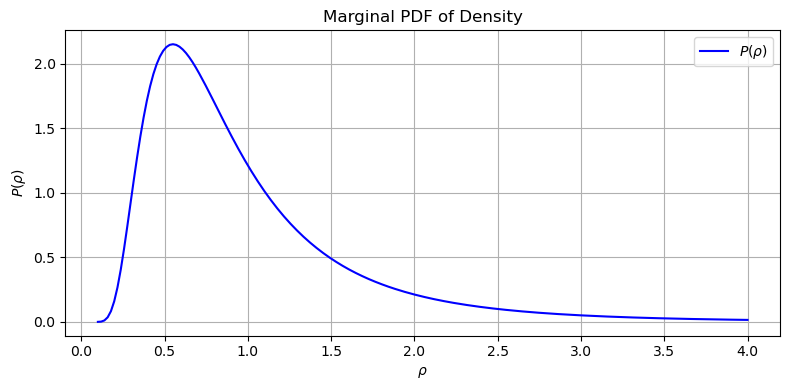

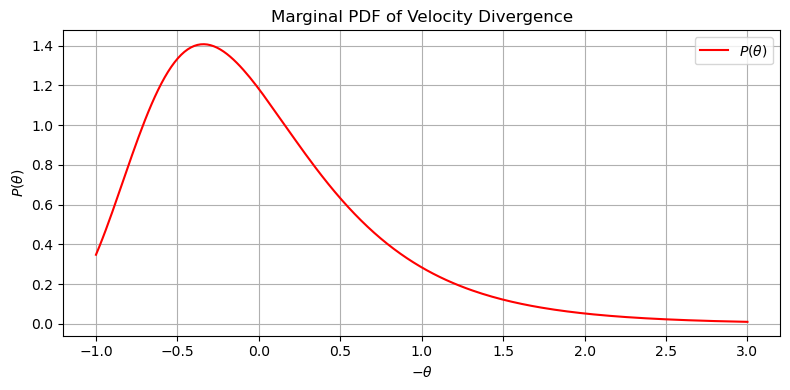

In [258]:
# Plot P(ρ) vs ρ
plt.figure(figsize=(8, 4))
plt.plot(rho_vals, P_rho, '-b', label=r'$P(\rho)$')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$P(\rho)$')
plt.title('Marginal PDF of Density')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Plot P(θ) vs θ
plt.figure(figsize=(8, 4))
plt.plot(-theta_vals, P_theta, '-r', label=r'$P(\theta)$')
plt.xlabel(r'$-\theta$')
plt.ylabel(r'$P(\theta)$')
plt.title('Marginal PDF of Velocity Divergence')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()


In [259]:
P_joint = np.zeros((len(rho_vals), len(theta_vals)))
for i, r in enumerate(rho_vals):
    for j, t in enumerate(theta_vals):
        P_joint[i,j] = P_rho_theta_fast(
            r, t,
            omegas=omegas,
            A_vals=A_NLO_full,
            W=W,
            const=const_joint
        )

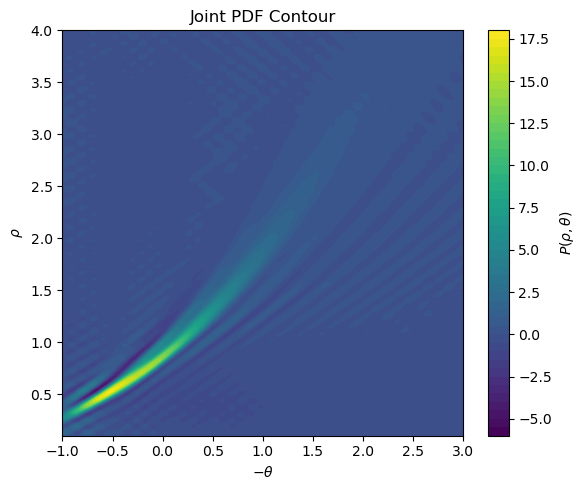

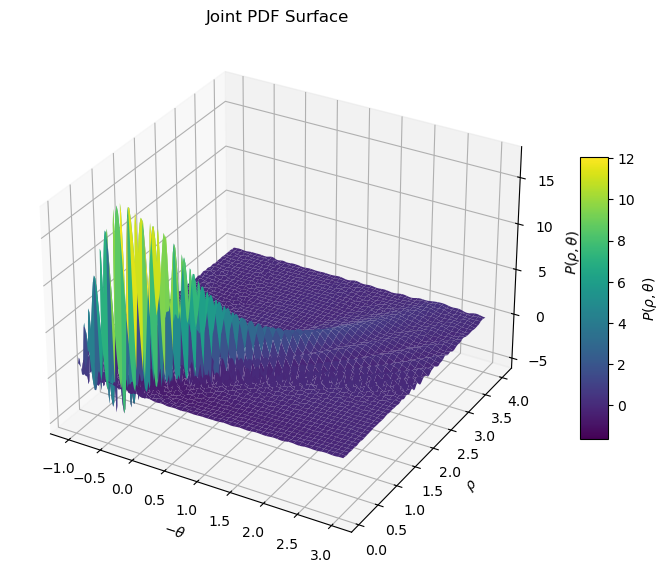

In [260]:
# === Block: Contour plot ===
R2, R1 = np.meshgrid(-theta_vals, rho_vals)   # x = θ, y = ρ

plt.figure(figsize=(6,5))
cont = plt.contourf(R2, R1, P_joint, levels=50, cmap='viridis')
plt.colorbar(cont, label=r'$P(\rho,\theta)$')
plt.xlabel(r'$-\theta$')
plt.ylabel(r'$\rho$')
plt.title('Joint PDF Contour')
plt.tight_layout()

# === Block: 3D surface plot ===
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(
    R2, R1, P_joint,
    cmap='viridis', linewidth=0, antialiased=True
)
fig.colorbar(surf, shrink=0.5, aspect=10, label=r'$P(\rho,\theta)$')
ax.set_xlabel(r'$-\theta$')
ax.set_ylabel(r'$\rho$')
ax.set_zlabel(r'$P(\rho,\theta)$')
ax.set_title('Joint PDF Surface')
ax.view_init(elev=30, azim=-60)
plt.tight_layout()
plt.show()